# Predicting Ames housing prices: exploratory data analysis
**Author**: [Alberto Bas](https://www.github.com/albertobas)<br />**Date published**: 01/03/2022<br />**Description**: exploratory data analysis on the _Ames housing prices_ dataset

<a title="Open in Colab" href="https://colab.research.google.com/github/albertobas/ames-housing-prices/blob/main/ames_housing_prices_eda.ipynb"><img alt="Open in Colab badge" align="left" width="117" height="20" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>
<br />
___

An exploratory analysis is introduced in this notebook in order to come up with a good understanding of the _Ames housing prices_ dataset. I'll make use of two simple forms of exploratory data visualizations: distribution (or distribution-based) plots and two-variable visualizations.

I am interested in knowing the shape of the data and the relations between the independent variables and the response. This visual exercise may enlighten us to insights and patterns which otherwise could have been harder to comprehend.

## Setup

In [1]:
%%capture
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from scipy.stats import norm, probplot
from sklearn.datasets import fetch_openml
from utils import plot_univariate, plot_bivariate
from IPython.display import display
pd.set_option('max_columns', 200)
warnings.filterwarnings('ignore')
sns.distributions._has_statsmodels=False # Estimating density with scipy

The dataset contains 79 values for every single observation, 80 in the training set considering the target value. There are 1460 observations in the training set and one less in the set that is used for testing the analysis, i.e., predicting the target variable, which is `SalePrice`. The only column that will not be used is `Id`.

In [2]:
X_train = fetch_openml(name="house_prices", as_frame=True, data_home='data')['frame']
X_train.drop(['Id'], axis=1, inplace=True)
for col in ['MSSubClass', 'OverallQual', 'OverallCond']:
    X_train[col] = X_train[col].astype('int')
display(X_train.head(2), X_train.shape)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450.0,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003.0,2003.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,8.0,Typ,0.0,None,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0.0,61.0,0.0,0.0,0.0,0.0,None,None,None,0.0,2.0,2008.0,WD,Normal,208500.0
1,20,RL,80.0,9600.0,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976.0,1976.0,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,TA,6.0,Typ,1.0,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298.0,0.0,0.0,0.0,0.0,0.0,None,None,None,0.0,5.0,2007.0,WD,Normal,181500.0


(1460, 80)

Input variables have been classified by their levels of measurement (ratio, interval, ordinal, nominal):

In [3]:
verbal = [f for f in X_train.columns if X_train.dtypes[f] == 'object']
numerical = [f for f in X_train.columns if X_train.dtypes[f] != 'object']
qualitative = verbal + ['MSSubClass', 'OverallQual', 'OverallCond']
quantitative = [n for n in numerical if n not in qualitative and n != 'SalePrice']
interval = ['GarageYrBlt', 'YearBuilt', 'YearRemodAdd', 'YrSold', 'MoSold']
ratio = [c for c in quantitative if c not in interval and c != 'SalePrice']
ratio.sort()
ordinal = ['LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'OverallQual', 'OverallCond', 
           'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
           'HeatingQC', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 
           'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence']
ordinal.sort()
nominal = [n for n in qualitative if n not in ordinal]
nominal.sort()


## The response: `SalePrice`
The plots on the left-hand side of the following figure show the distribution of all the prices that I will 
use to supervise the analysis and the probability plot of all this samples.

We can see positive skewness and kurtosis, there is a long tail to the right and the distribution is very peaked around the mean, so our response does not follow a normal distribution (shown in black).

However, this is partially rectified after a log-transformation as can be seen in the probability and distribution plots on the right-hand side: the distribution follows the diagonal closely in the corresponding probabilty plot and the density is closer to the normal shape.

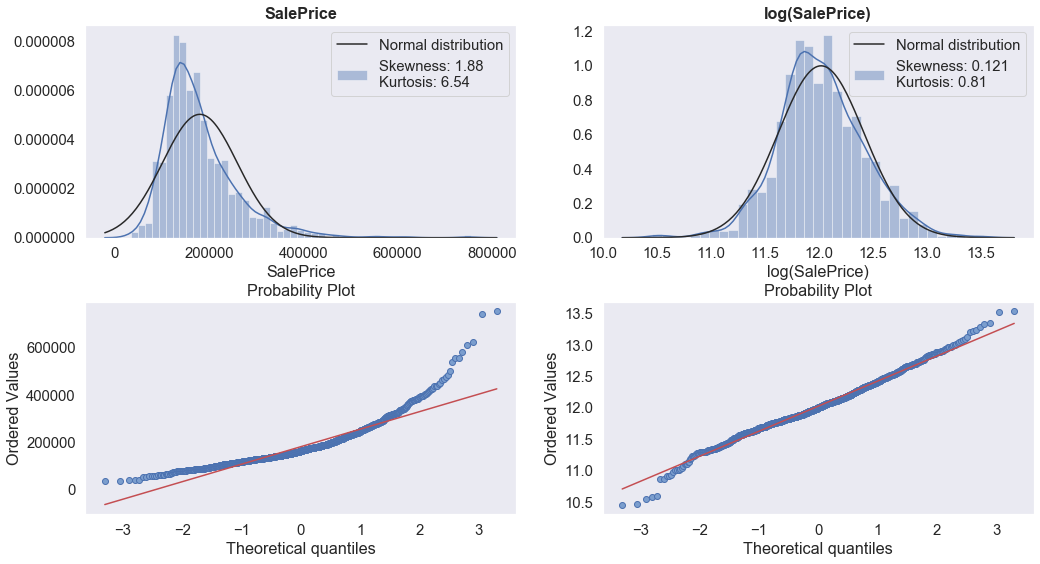

In [4]:
sns.set(font_scale=1.35, style='dark');
fig = plt.figure(figsize=(17,9));
plt.subplots_adjust(hspace=.3);
title = ['SalePrice', 'log(SalePrice)']
for i, y in enumerate([X_train['SalePrice'], np.log(X_train['SalePrice'])]*2, start=1):
    ax = plt.subplot(2, 2, i);
    if i<3:
        sns.distplot(y, fit=norm, ax=ax);
        ax.legend(['Normal distribution', 'Skewness: {:.3}\nKurtosis: {:.3}'.format(y.skew(), 
                                                                                    y.kurt())],
                  loc='best');
        ax.set_title(title[i-1], fontdict={'fontweight':'bold'})
        ax.set_xlabel(title[i-1])
    else:
        probplot(y, plot=ax);
        ax.get_lines()[0].set_markerfacecolor('#7b9ece')
plt.show()

In [5]:
X_train[['SalePrice']].describe()

,SalePrice
count,1460.000000
mean,180921.195890
std,79442.502883
min,34900.000000
25%,129975.000000
50%,163000.000000
75%,214000.000000
max,755000.000000



## The predictors

A graphical analysis will be performed first, looking at the predictors one by one, and then at the plots of the predictors as a function of the response. The figures are classified by level of measurement: ratio, interval, ordinal and nominal. I'll be using this [two functions](utils/eda.py 'EDA functions') to plot the graphics.


### Univariate analysis

This analysis is helpful to find out some particularities in the data:

* The vast majority of houses have less than 2000 square feet above grade living area and less than 20000 square feet of lot area.

* The distribution plot of `TotalBsmtSF` shows that most of the houses have a basement.

* Most of the houses have between 5 and 7 rooms above grade, nonetheless, there are houses with up to 14 rooms above grade.

* There are a few houses with more than one kitchen above grade and some without bedrooms.

* Most of the properties have either 1 or 2 full baths but there are a few with 3 and some others without full bathrooms.

* Most of the properties have enough space for up to two cars in the garage.

* Most of the houses do not have a pool nor a porch.

In [6]:
# Ratio-measured variables
X_train[ratio].describe()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,GarageCars,GrLivArea,HalfBath,KitchenAbvGr,LotArea,LotFrontage,LowQualFinSF,MasVnrArea,MiscVal,OpenPorchSF,PoolArea,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1201.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,1162.626712,346.992466,3.409589,2.866438,443.639726,46.549315,0.425342,0.057534,567.240411,21.954110,0.613014,1.565068,472.980137,1.767123,1515.463699,0.382877,1.046575,10516.828082,70.049958,5.844521,103.685262,43.489041,46.660274,2.758904,15.060959,6.517808,1057.429452,94.244521
std,386.587738,436.528436,29.317331,0.815778,456.098091,161.319273,0.518911,0.238753,441.866955,61.119149,0.644666,0.550916,213.804841,0.747315,525.480383,0.502885,0.220338,9981.264932,24.284752,48.623081,181.066207,496.123024,66.256028,40.177307,55.757415,1.625393,438.705324,125.338794
min,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,1300.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000
25%,882.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,223.000000,0.000000,0.000000,1.000000,334.500000,1.000000,1129.500000,0.000000,1.000000,7553.500000,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,795.750000,0.000000
50%,1087.000000,0.000000,0.000000,3.000000,383.500000,0.000000,0.000000,0.000000,477.500000,0.000000,1.000000,2.000000,480.000000,2.000000,1464.000000,0.000000,1.000000,9478.500000,69.000000,0.000000,0.000000,0.000000,25.000000,0.000000,0.000000,6.000000,991.500000,0.000000
75%,1391.250000,728.000000,0.000000,3.000000,712.250000,0.000000,1.000000,0.000000,808.000000,0.000000,1.000000,2.000000,576.000000,2.000000,1776.750000,1.000000,1.000000,11601.500000,80.000000,0.000000,166.000000,0.000000,68.000000,0.000000,0.000000,7.000000,1298.250000,168.000000
max,4692.000000,2065.000000,508.000000,8.000000,5644.000000,1474.000000,3.000000,2.000000,2336.000000,552.000000,3.000000,3.000000,1418.000000,4.000000,5642.000000,2.000000,3.000000,215245.000000,313.000000,572.000000,1600.000000,15500.000000,547.000000,738.000000,480.000000,14.000000,6110.000000,857.000000


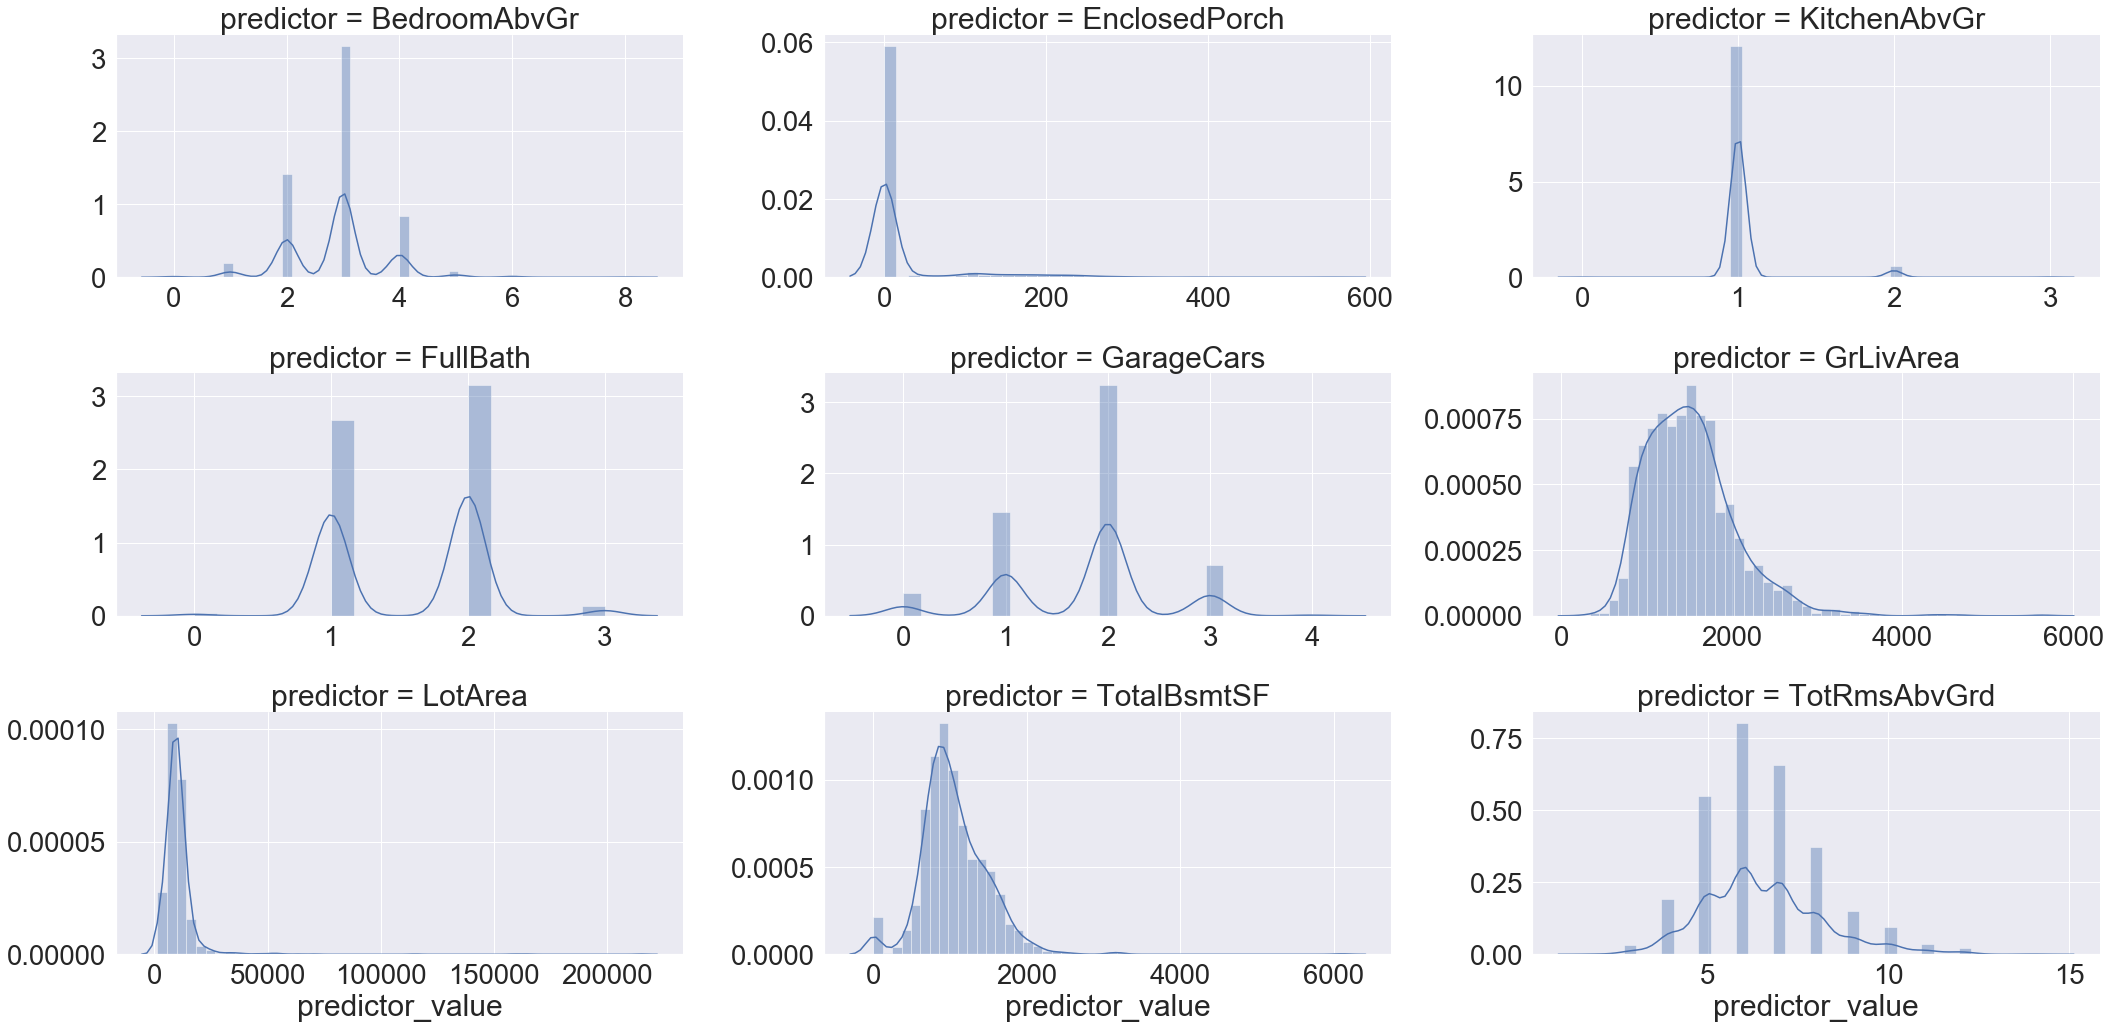

In [7]:
# add '3SsnPorch', 'OpenPorchSF', 'ScreenPorch' below to check the rest of the variables with values for Porch
ratio_vars = ['BedroomAbvGr', 'EnclosedPorch', 'KitchenAbvGr', 'FullBath', 'GarageCars', 
              'GrLivArea', 'LotArea', 'TotalBsmtSF', 'TotRmsAbvGrd']
plot_univariate(X_train, ratio_vars, 2.5, 3, 5, 2, sns.distplot)

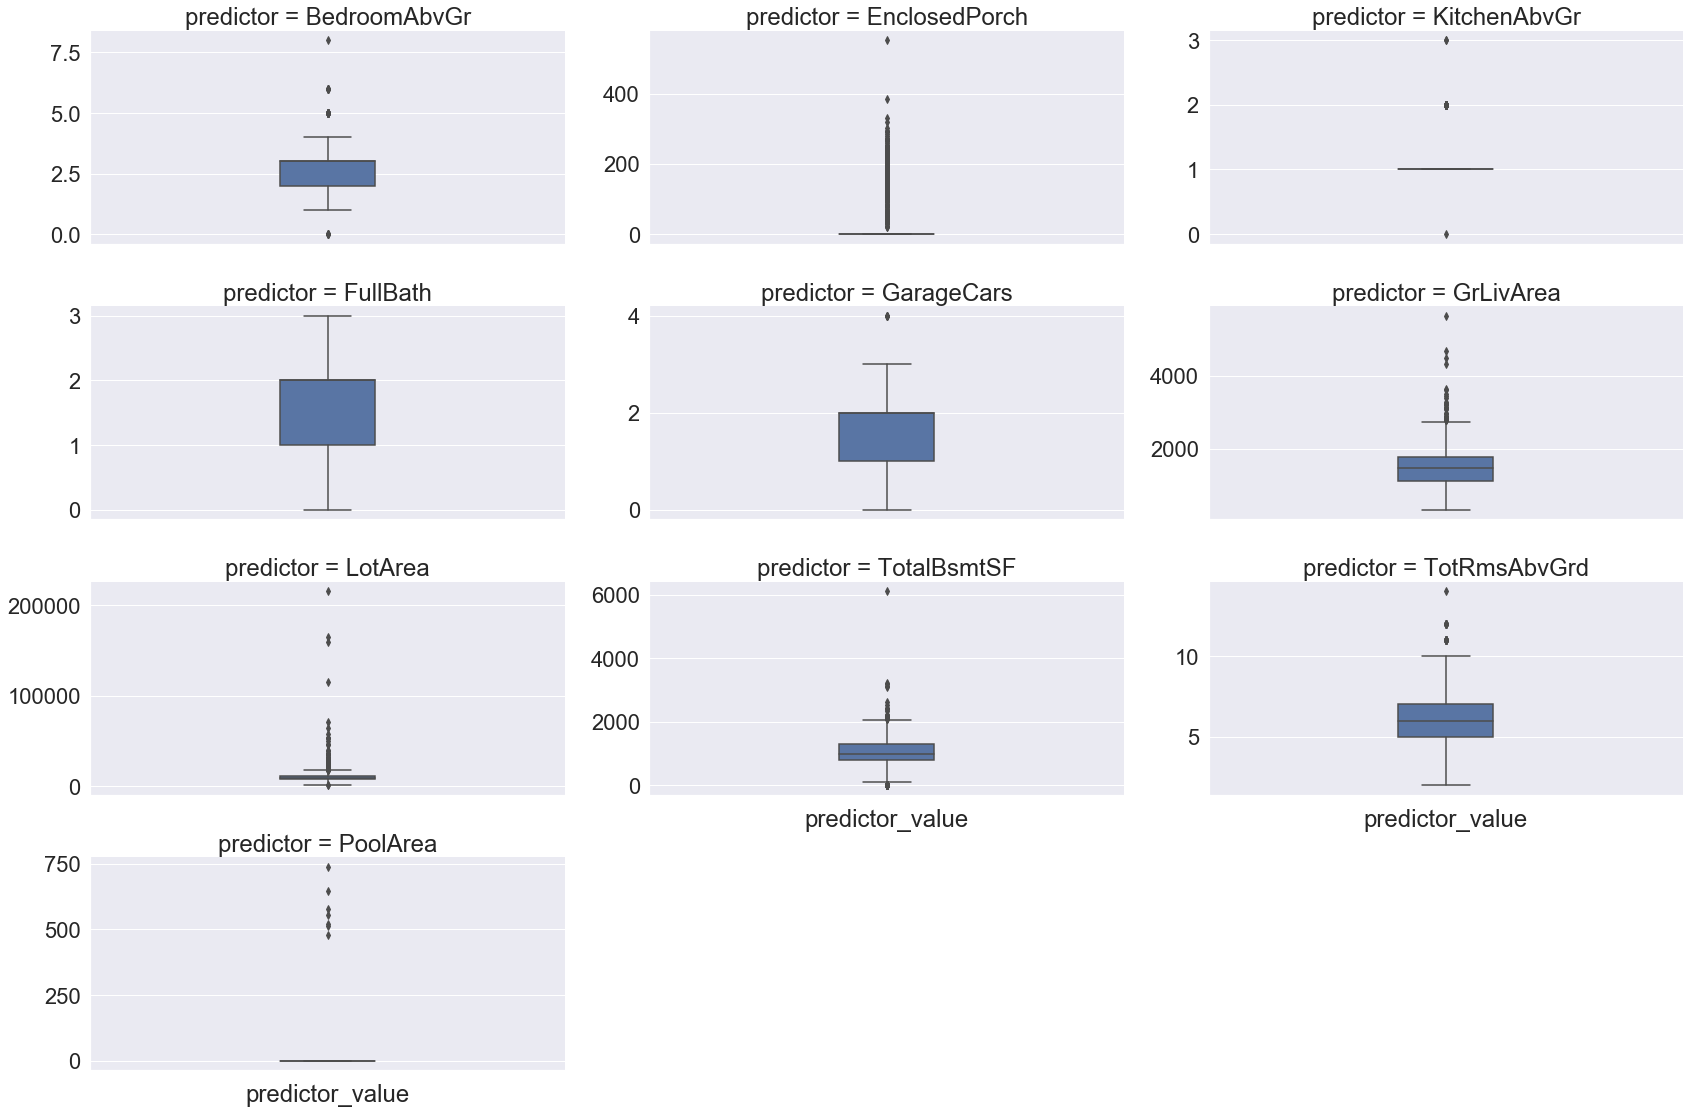

In [8]:
plot_univariate(X_train, ratio_vars+['PoolArea'], 2, 3, 4, 2, sns.boxplot)

* There are observations in `YearRemodAdd` from 1950 onwards and, given the huge difference in quantity from this year to the following fifty years, it is likely there is a lower bound in their values. Moreover, as new properties most likely do not need remodelling and `YearRemodAdd` does not contain missing values, many of the values, apart from those for the houses with `YearRemodAdd` of 1950, may have been somehow prescriptively imputed.

In [9]:
# Interval-measured variables
X_train[interval].describe()

,GarageYrBlt,YearBuilt,YearRemodAdd,YrSold,MoSold
count,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,1978.506164,1971.267808,1984.865753,2007.815753,6.321918
std,24.689725,30.202904,20.645407,1.328095,2.703626
min,1900.000000,1872.000000,1950.000000,2006.000000,1.000000
25%,1961.000000,1954.000000,1967.000000,2007.000000,5.000000
50%,1980.000000,1973.000000,1994.000000,2008.000000,6.000000
75%,2002.000000,2000.000000,2004.000000,2009.000000,8.000000
max,2010.000000,2010.000000,2010.000000,2010.000000,12.000000


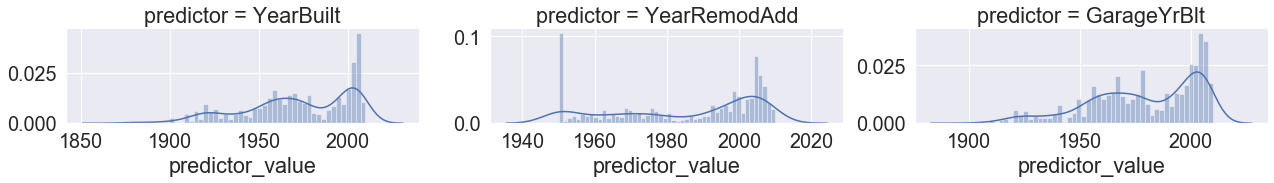

In [10]:
interval_vars = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']
plot_univariate(X_train, interval_vars, 1.8, 3, 3, 2, sns.distplot, bins=50)

* Obviously, there is a tight relation between predictors as `GarageYrBlt` and `YearBuilt`, or `GarageArea` and `GarageCars`, however, given the fact that most of the houses have garage and the distribution of `GarageYrBlt` and `YearBuilt` is slightly different, it is likely that either the garage in many properties has been built later or that the garage unit and the house are separate properties and consequently both have most likely been built in different years.

In [11]:
print("Number of houses with garage:", 
      X_train[X_train['GarageArea']>0].shape[0],
      "\nNumber of houses built the same year as the garage:", 
      X_train[(X_train['GarageArea']>0) & 
              (X_train['YearBuilt']==X_train['GarageYrBlt'])].shape[0])

Number of houses with garage: 1379 
Number of houses built the same year as the garage: 1089


* There have been many more houses sold during the summer season. Also, the number of houses sold from year to year since 2006 has not changed vastly except for 2010, however, this is because the training set has records of houses that have been sold only until July 2010 as we can see below:

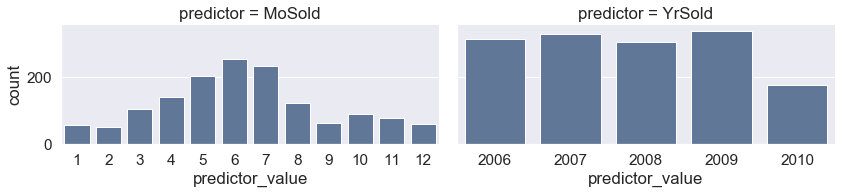

In [12]:
interval_vars2 = ['MoSold', 'YrSold']
plot_univariate(X_train, interval_vars2, 1.4, 2, 3, 2, sns.barplot)

In [13]:
display(pd.DataFrame(X_train['YrSold'].value_counts()))
print("Last month with records in 2010: ", X_train[X_train['YrSold']==2010]['MoSold'].max())

,YrSold
2009.0,338
2007.0,329
2006.0,314
2008.0,304
2010.0,175


Last month with records in 2010:  7.0


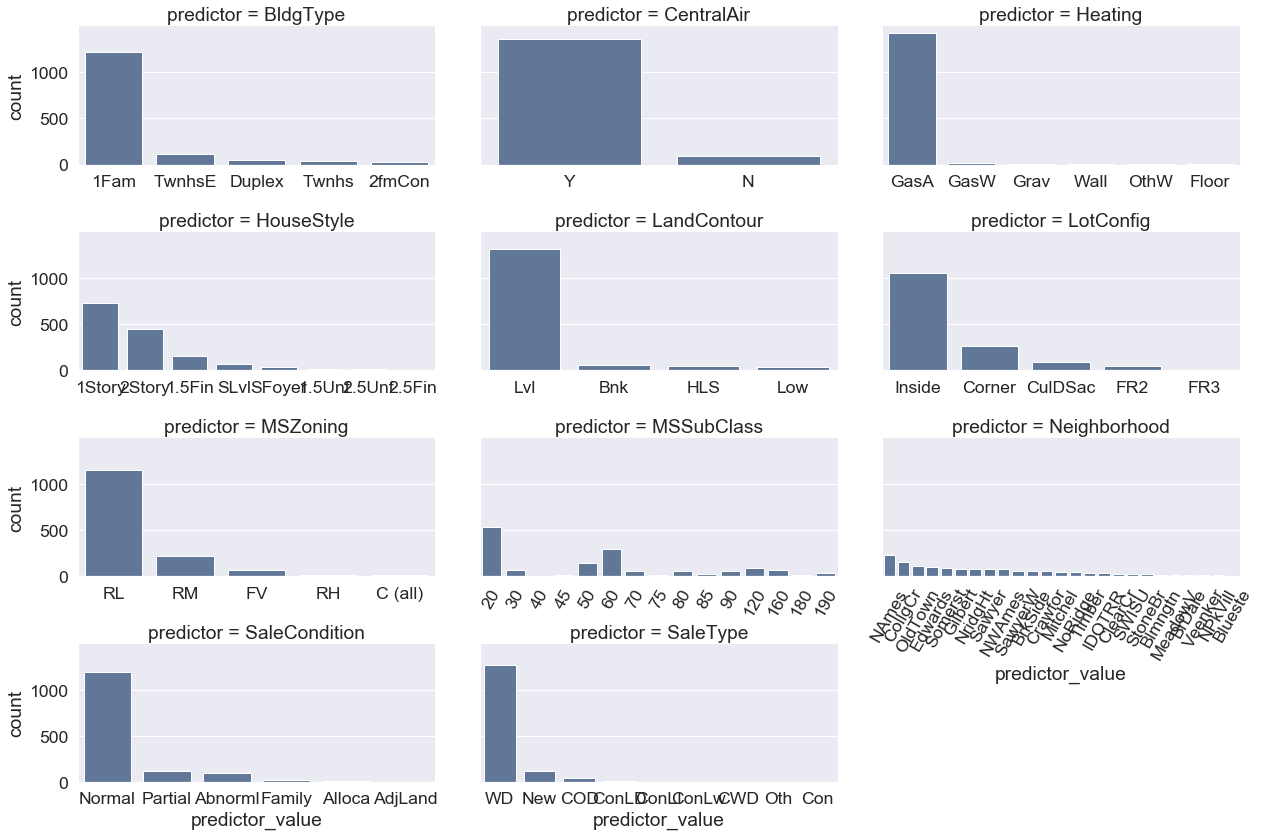

In [14]:
# Nominal-measured variables
nominal_vars = ['BldgType', 'CentralAir', 'Heating', 'HouseStyle', 'LandContour', 'LotConfig', 
                'MSZoning', 'MSSubClass', 'Neighborhood', 'SaleCondition', 'SaleType']
plot_univariate(X_train, nominal_vars, 1.6, 3, 3, 2, sns.barplot, labels_thresh=9, rotation=60)

* The vast majority of houses have central air conditioning and also gas forced warm air furnaces as their type of heating.

* Most of the houses have been built in a residential area with low density.

In [15]:
# Ordinal-measured variables
X_train['OverallCond'] = X_train['OverallCond'].astype('category')
X_train['OverallQual'] = X_train['OverallQual'].astype('category')
frame = X_train[ordinal].describe()
frame.index = ["count", 'unique', 'mode', 'freq']
display(frame)
X_train['OverallCond'] = X_train['OverallCond'].astype('int')
X_train['OverallQual'] = X_train['OverallQual'].astype('int')

,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,Electrical,ExterCond,ExterQual,Fence,FireplaceQu,Functional,GarageCond,GarageFinish,GarageQual,HeatingQC,KitchenQual,LandSlope,LotShape,OverallCond,OverallQual,PavedDrive,PoolQC,Utilities
count,1423,1422,1423,1422,1423,1459,1460,1460,281,770,1460,1379,1379,1379,1460,1460,1460,1460,1460,1460,1460,7,1460
unique,4,4,6,6,4,5,5,4,4,5,7,5,3,5,5,4,3,4,9,10,3,3,2
mode,TA,No,Unf,Unf,TA,SBrkr,TA,TA,MnPrv,Gd,Typ,TA,Unf,TA,Ex,TA,Gtl,Reg,5,5,Y,Gd,AllPub
freq,1311,953,430,1256,649,1334,1282,906,157,380,1360,1326,605,1311,741,735,1382,925,821,397,1340,3,1459


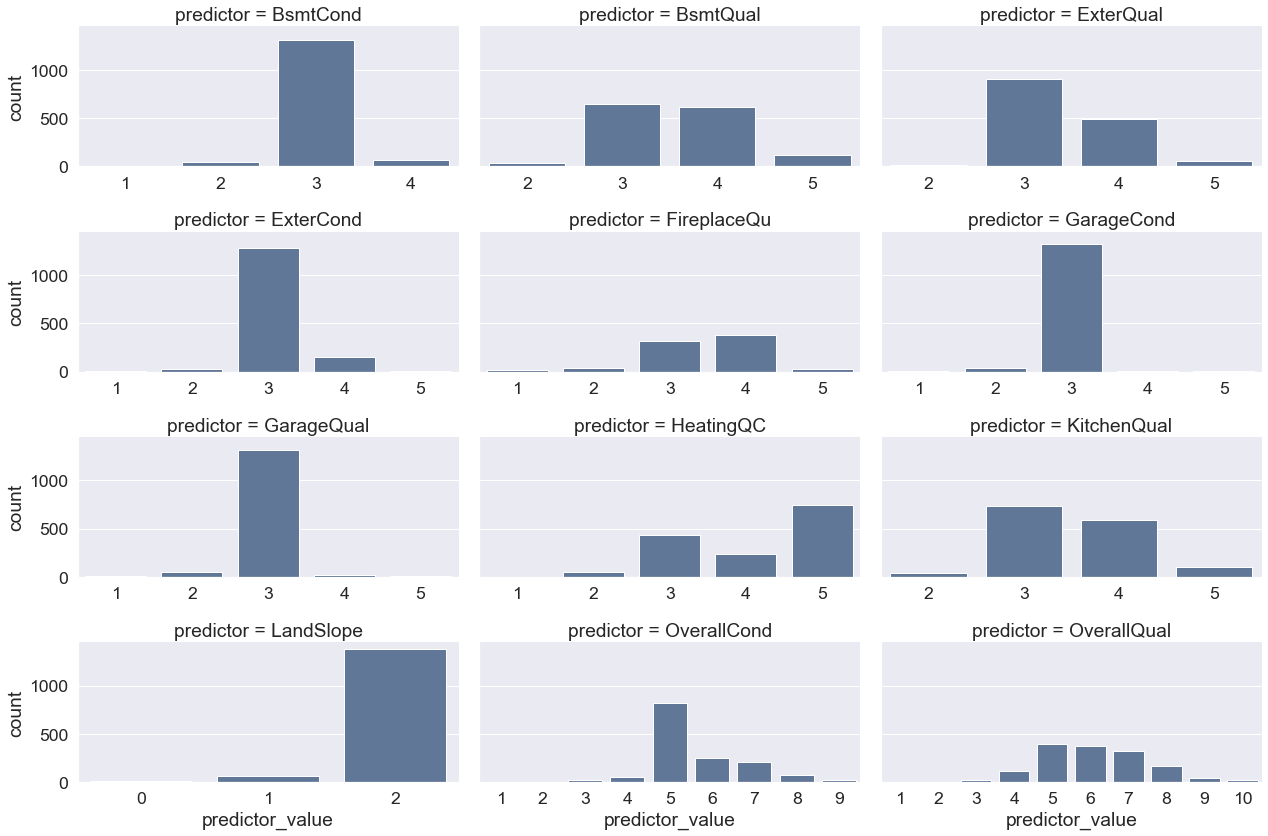

In [16]:
ordinal_vars = ['BsmtCond', 'BsmtQual', 'ExterQual', 'ExterCond',  'FireplaceQu', 'GarageCond', 
                'GarageQual', 'HeatingQC', 'KitchenQual', 'LandSlope', 'OverallCond', 
                'OverallQual']
frame_ordinal = X_train[ordinal_vars].copy()
Bsmt_Fireplace_Garage_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.nan: 0}
Exter_Heating_Kitchen_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
LandSlope_mapping = {'Gtl': 2, 'Mod': 1, 'Sev': 0}
frame_ordinal['BsmtCond'] = frame_ordinal['BsmtCond'].map(Bsmt_Fireplace_Garage_mapping)
frame_ordinal['BsmtQual'] = frame_ordinal['BsmtQual'].map(Bsmt_Fireplace_Garage_mapping)
frame_ordinal['ExterQual'] = frame_ordinal['ExterQual'].map(Exter_Heating_Kitchen_mapping)
frame_ordinal['ExterCond'] = frame_ordinal['ExterCond'].map(Exter_Heating_Kitchen_mapping)
frame_ordinal['FireplaceQu'] = frame_ordinal['FireplaceQu'].map(Bsmt_Fireplace_Garage_mapping)
frame_ordinal['GarageCond'] = frame_ordinal['GarageCond'].map(Bsmt_Fireplace_Garage_mapping)
frame_ordinal['GarageQual'] = frame_ordinal['GarageQual'].map(Bsmt_Fireplace_Garage_mapping)
frame_ordinal['HeatingQC'] = frame_ordinal['HeatingQC'].map(Exter_Heating_Kitchen_mapping)
frame_ordinal['KitchenQual'] = frame_ordinal['KitchenQual'].map(Exter_Heating_Kitchen_mapping)
frame_ordinal['LandSlope'] = frame_ordinal['LandSlope'].map(LandSlope_mapping)
plot_univariate(frame_ordinal, ordinal_vars, 1.6, 3, 3, 2, sns.barplot)

* Most of the properties are nearly flat (gentle land slope). This may obviously be due to the neighborhood or area where they have been built. However, there may be some exceptions that may distinguish the houses among others in the same area. 

Some other possible distinctions are houses that have different ratings in `OverallQual` or in `OverallCond` or different `LotArea` within the same neighborhood. 

Since these differences might result in an increase or decrease of the price, we might need to create some features to explain this information in case our model wasn't able to capture or explain this proportion of variance in the response.

For example, outliers and patterns after plotting the residuals once the model is fit since this might indicate a deficiency in the analysis, such as a missing feature.


### Bivariate analysis

The plots below help us to identify some observations that are out of the general trend of the rest of the data in each of the predictor and target spaces. 

For example, we know from the box plot of `GrLivArea` that it contains observations over the max whisker reach, i.e., with extreme value in the predictor space, but now, as we can see below, we can say that two out of this four suspected outliers are true outliers, in the sense that they do not follow the general trend of the data.

Another clear example is the property with over 6000 sf of basement in `TotalBsmtSF`, which by the price might be one of the previously defined outliers.

On the other hand, the other two observations in `GrLivArea` with more than 4000 sf are in accordance with the rest of the points or, at least, we could say they follow the trend of the rest of the houses.

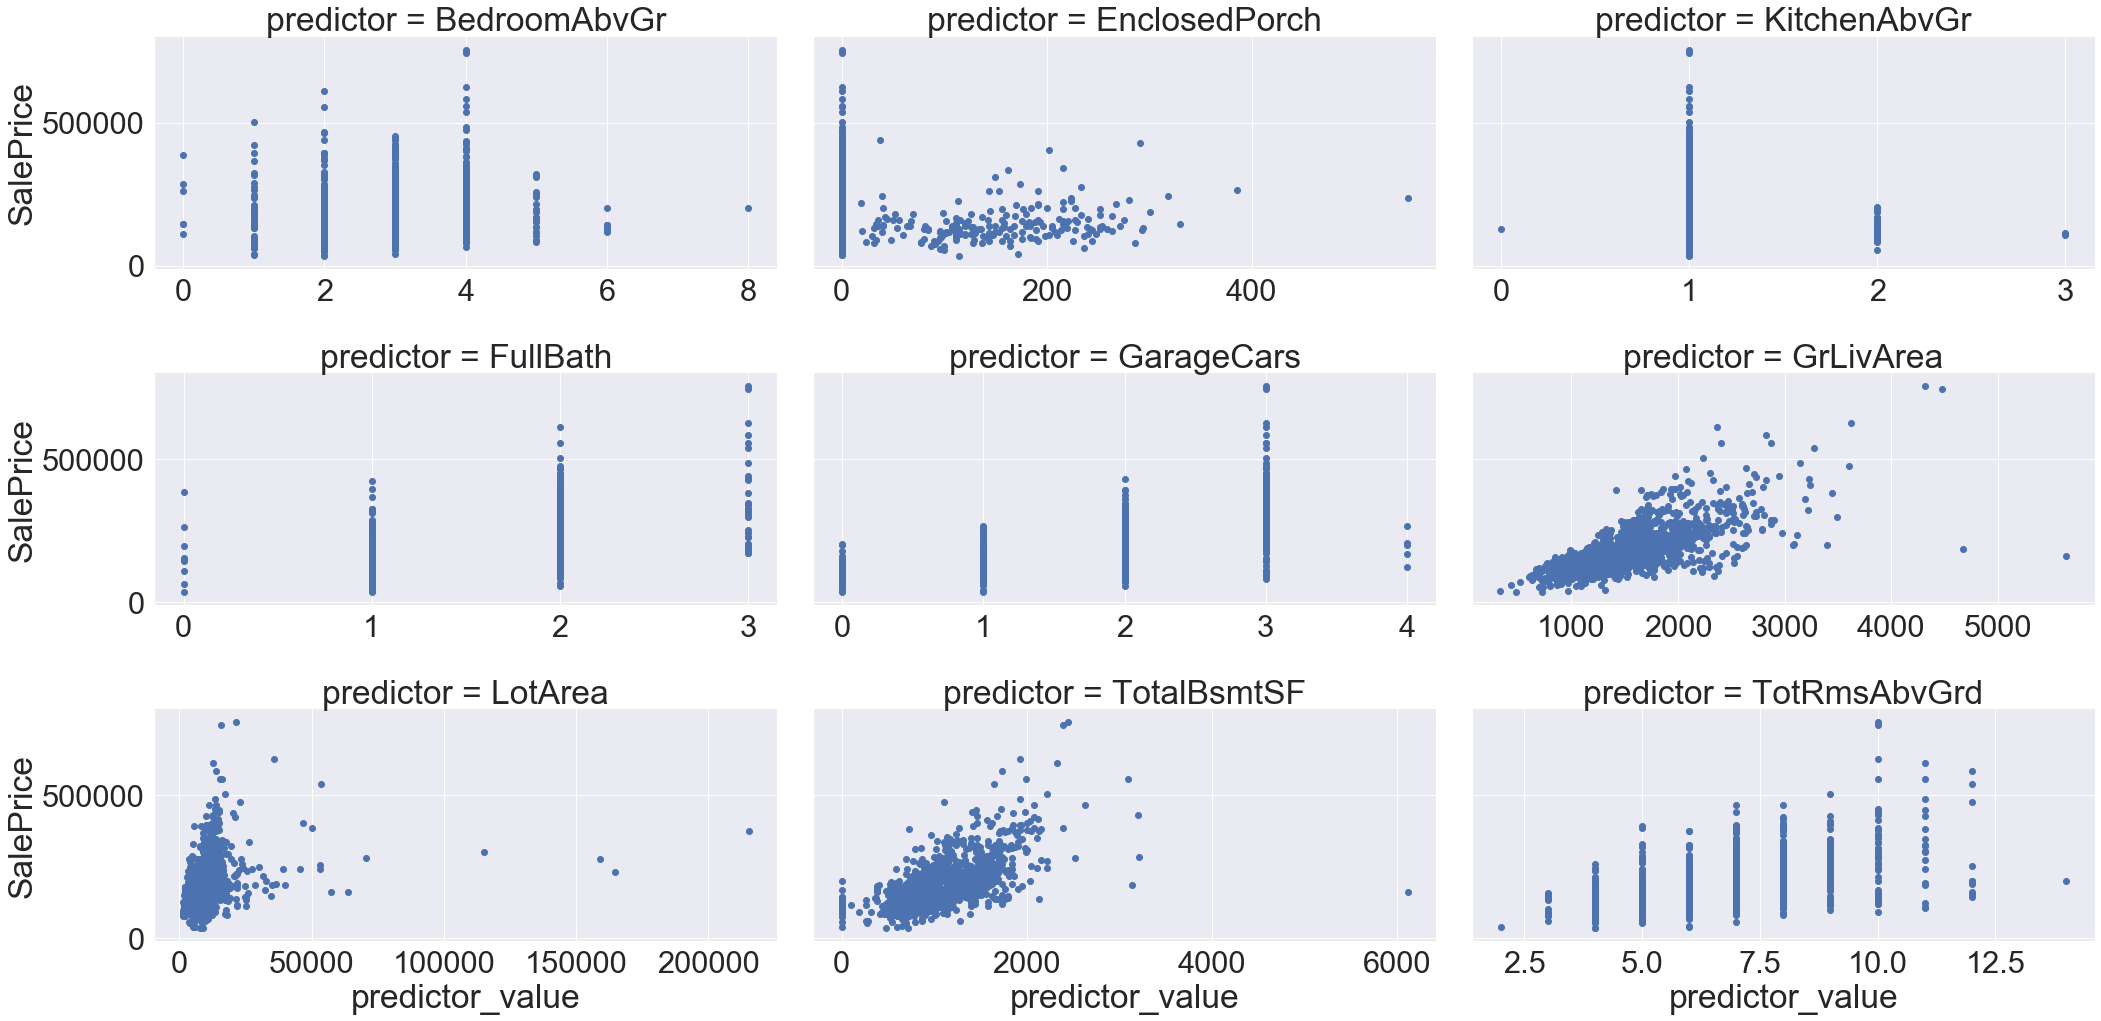

In [17]:
# Ratio-measured variables and 'SalePrice'
plot_bivariate(X_train, 'SalePrice', ratio_vars, 2.8, 3, 5, 2, plt.scatter)

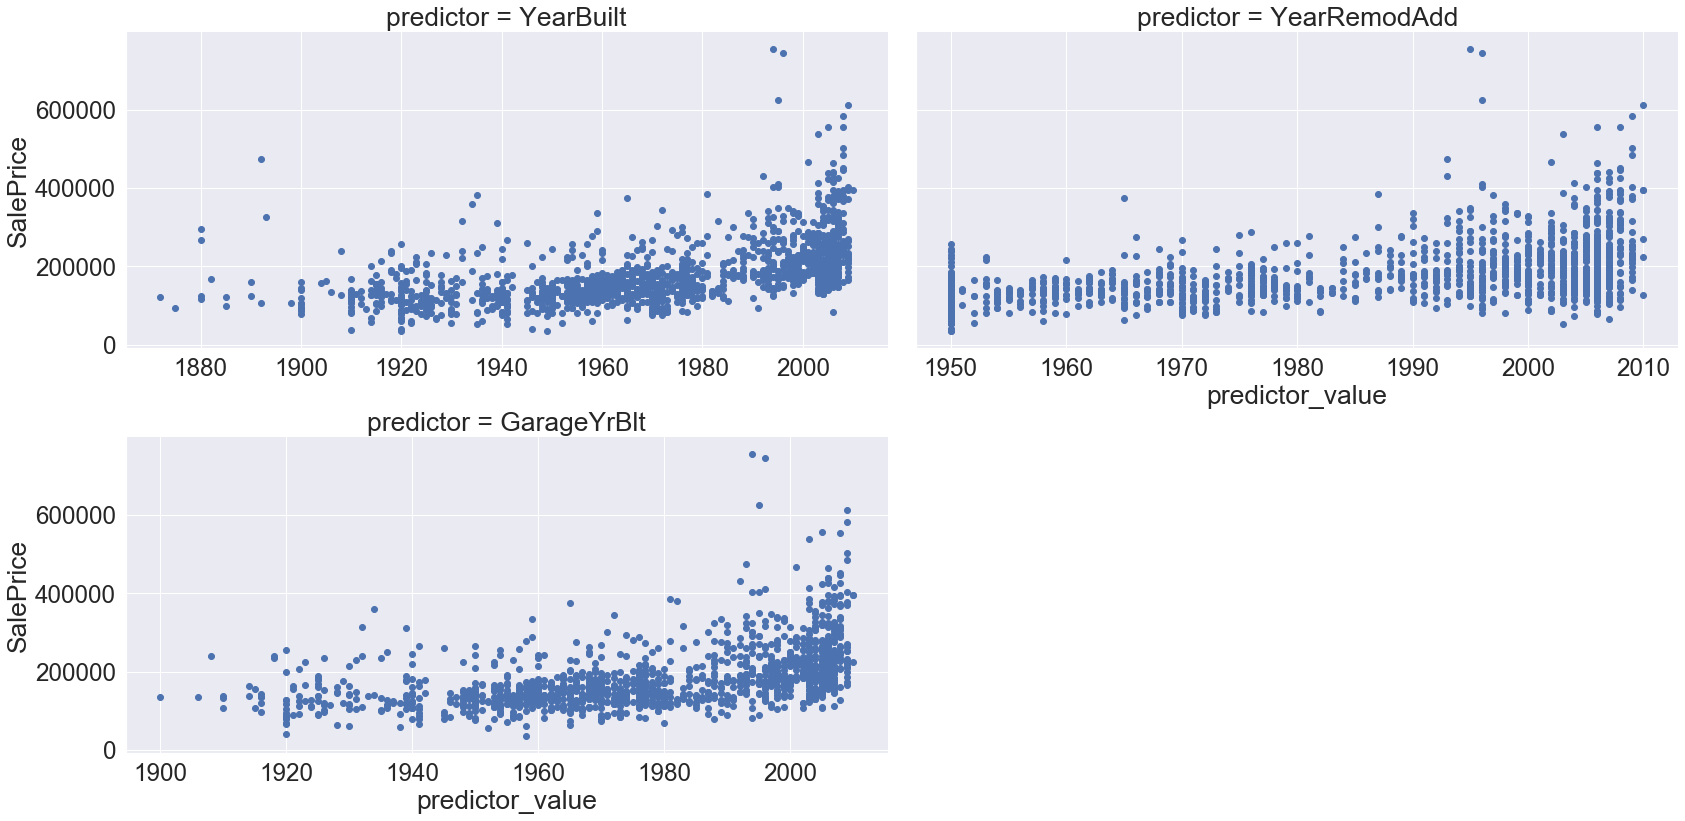

In [18]:
# Interval-measured variables and 'SalePrice'
plot_bivariate(X_train, 'SalePrice', interval_vars, 2.2, 2, 6, 2, plt.scatter)

Some houses have the same values in `YearRemodAdd` as in `YearBuilt` so they have not yet been remodeled, i.e. some of their values might have been prescriptively imputed. This may be due to the fact that the property has just been built or that it is in good condition. 

However, it might not always be the case as we can see in the Series below. There are 39 properties in the training set with an `OverallCond` lower than 5 that were built the same year that the data set specifies were remodeled:

In [19]:
pd.DataFrame(X_train[(X_train['YearRemodAdd']==X_train['YearBuilt'])&
                     (X_train['OverallCond']<5)]['OverallCond'].value_counts())

,OverallCond
4,25
3,13
2,1


> The creation of some features might capture information that could explain the difference of time between `YearBuilt` and `YrSold`, or between `YearBuilt` and `YearRemodAdd`, or between `YearRemodAdd` and `YrSold`. This is, there might be a pattern that could help in predicting the price.

As we can see below in both, left plot and DataFrame, the month with the lowest median of `SalePrice` is April. January, August and November are the months when there is more variability in the price of the houses being sold.


Although there are only 1460 observations in this set, we can say the first half of the year and July are when there are more properties distant from the bulk of the data, this is, perhaps this represents the type of houses that are not usually sold during the rest of the year.


Also, October does not look like the best month for real estate agents. Neither was 2008 in general.

> Although the median for 2010 is even lower than the median in 2008 there are only houses in this set until July, 2010 as was shown earlier.

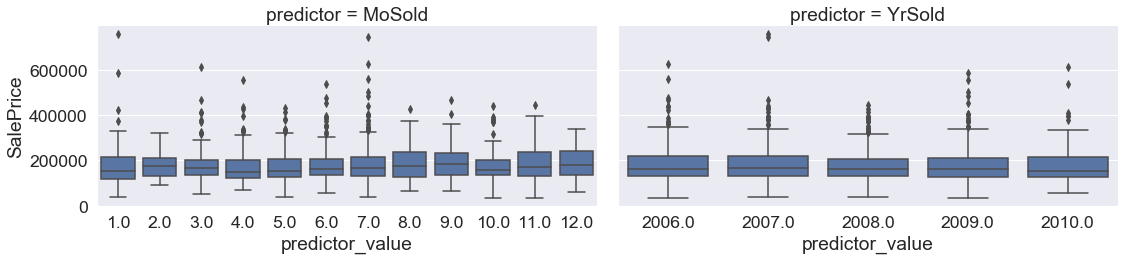

In [20]:
plot_bivariate(X_train, 'SalePrice', interval_vars2, 1.6, 2, 4, 2, 
               sns.boxplot)

In [21]:
pd.DataFrame(X_train.groupby(['MoSold'])
             ['SalePrice'].median().sort_values().head(3))

,SalePrice
MoSold,
4.0,147000.0
1.0,151650.0
5.0,154000.0


Below are boxplots of some encoded ordinal predictors against `SalePrice` . The encoding helps to understand how the order influences the sale price.

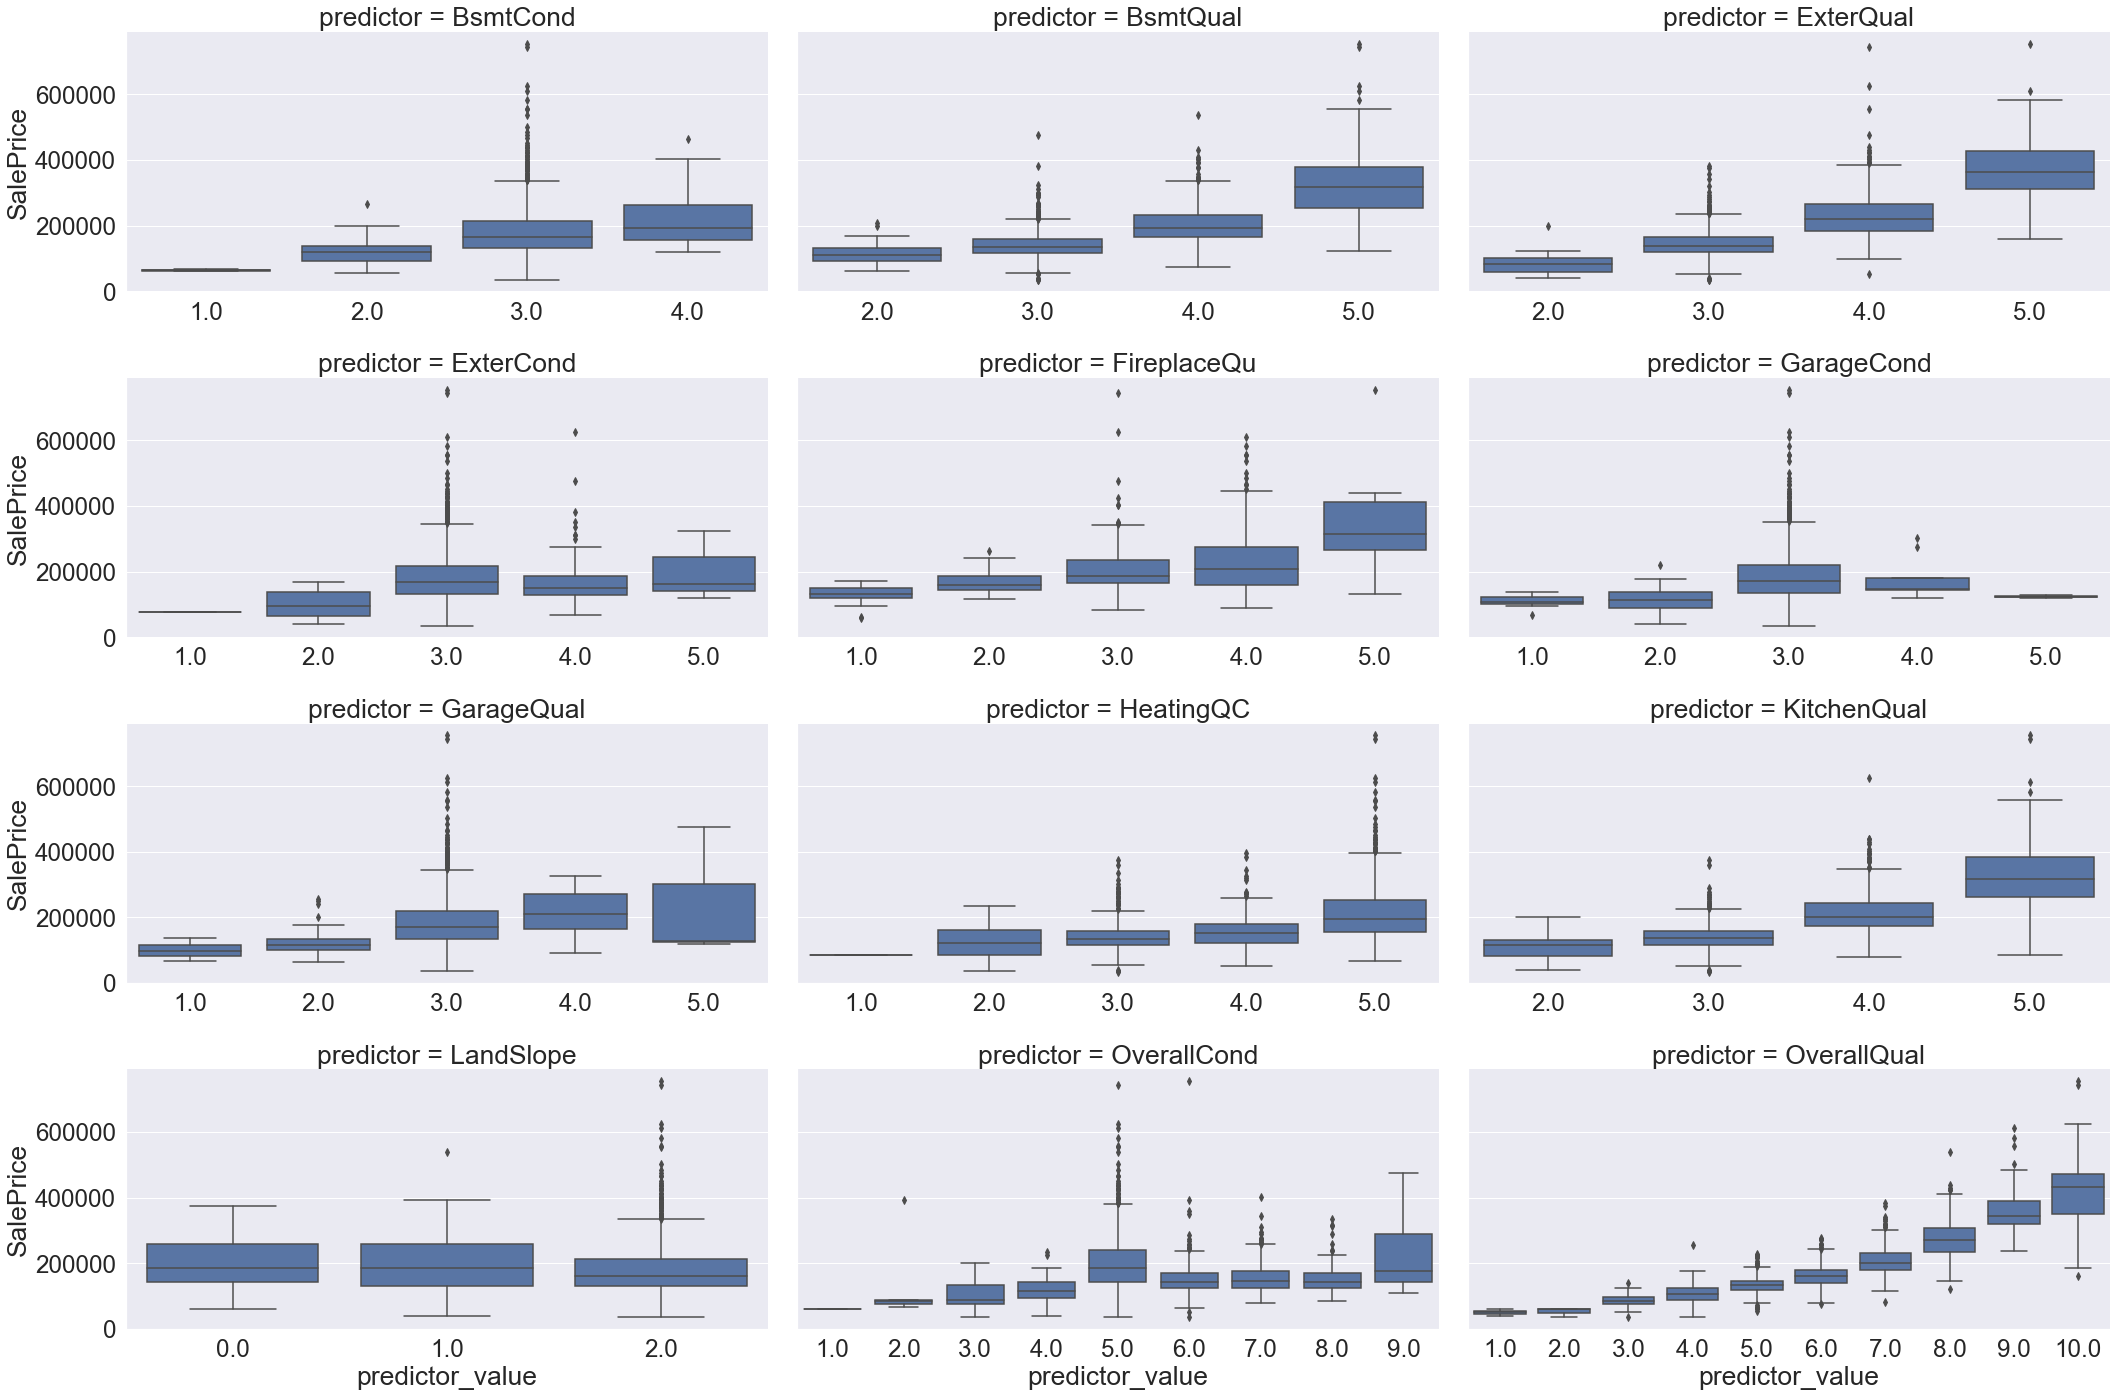

In [22]:
# Ordinal predictors and Sale Price
# Please refer to the mapping in univariate ordinal plot in order to check the x-labels
frame_ordinal = pd.concat([frame_ordinal, X_train['SalePrice']], axis=1)
plot_bivariate(frame_ordinal, 'SalePrice', ordinal_vars, 2.2, 3, 5, 2, 
               sns.boxplot)

Most of the times there is a positive correlation between the price and the ordinal predictors, however, if we take into account only the predictors that measure conditions, more is not always better, or a better condition may not translate to a higher price.

In fact, 73.84% of the first 730 most expensive houses in the set (half the dataset) have an `OverallCond` of five out of nine:

In [23]:
series_cond = X_train.sort_values(by='SalePrice', 
                                  ascending=False)['OverallCond'][:730].value_counts()
pd.DataFrame([series_cond, np.round(series_cond/series_cond.sum()*100, 2)], 
             index=['n_houses', '%']).T

,n_houses,%
5,539.0,73.84
6,80.0,10.96
7,66.0,9.04
8,20.0,2.74
9,13.0,1.78
4,8.0,1.10
3,3.0,0.41
2,1.0,0.14


Or we can also say that 93% of the houses with an `OverallQual` of 9 or higher have been rated with an `OverallCond` of 5 out of 9:

In [24]:
series_cond = X_train[X_train['OverallQual']>8]['OverallCond'].value_counts()
pd.DataFrame([series_cond, np.round(series_cond/series_cond.sum()*100, 2)], 
             index=['n_houses', '%']).T

,n_houses,%
5,57.0,93.44
9,2.0,3.28
6,1.0,1.64
2,1.0,1.64


As we can see below, and as expected, the price of the properties fluctuates greatly depending on the neighborhood and also on the type of dwelling (`MSSubClass`) amongst others. For instance, 1 square feet is very differently rated in _StoneBr_ as it is in _IDOTRR_.

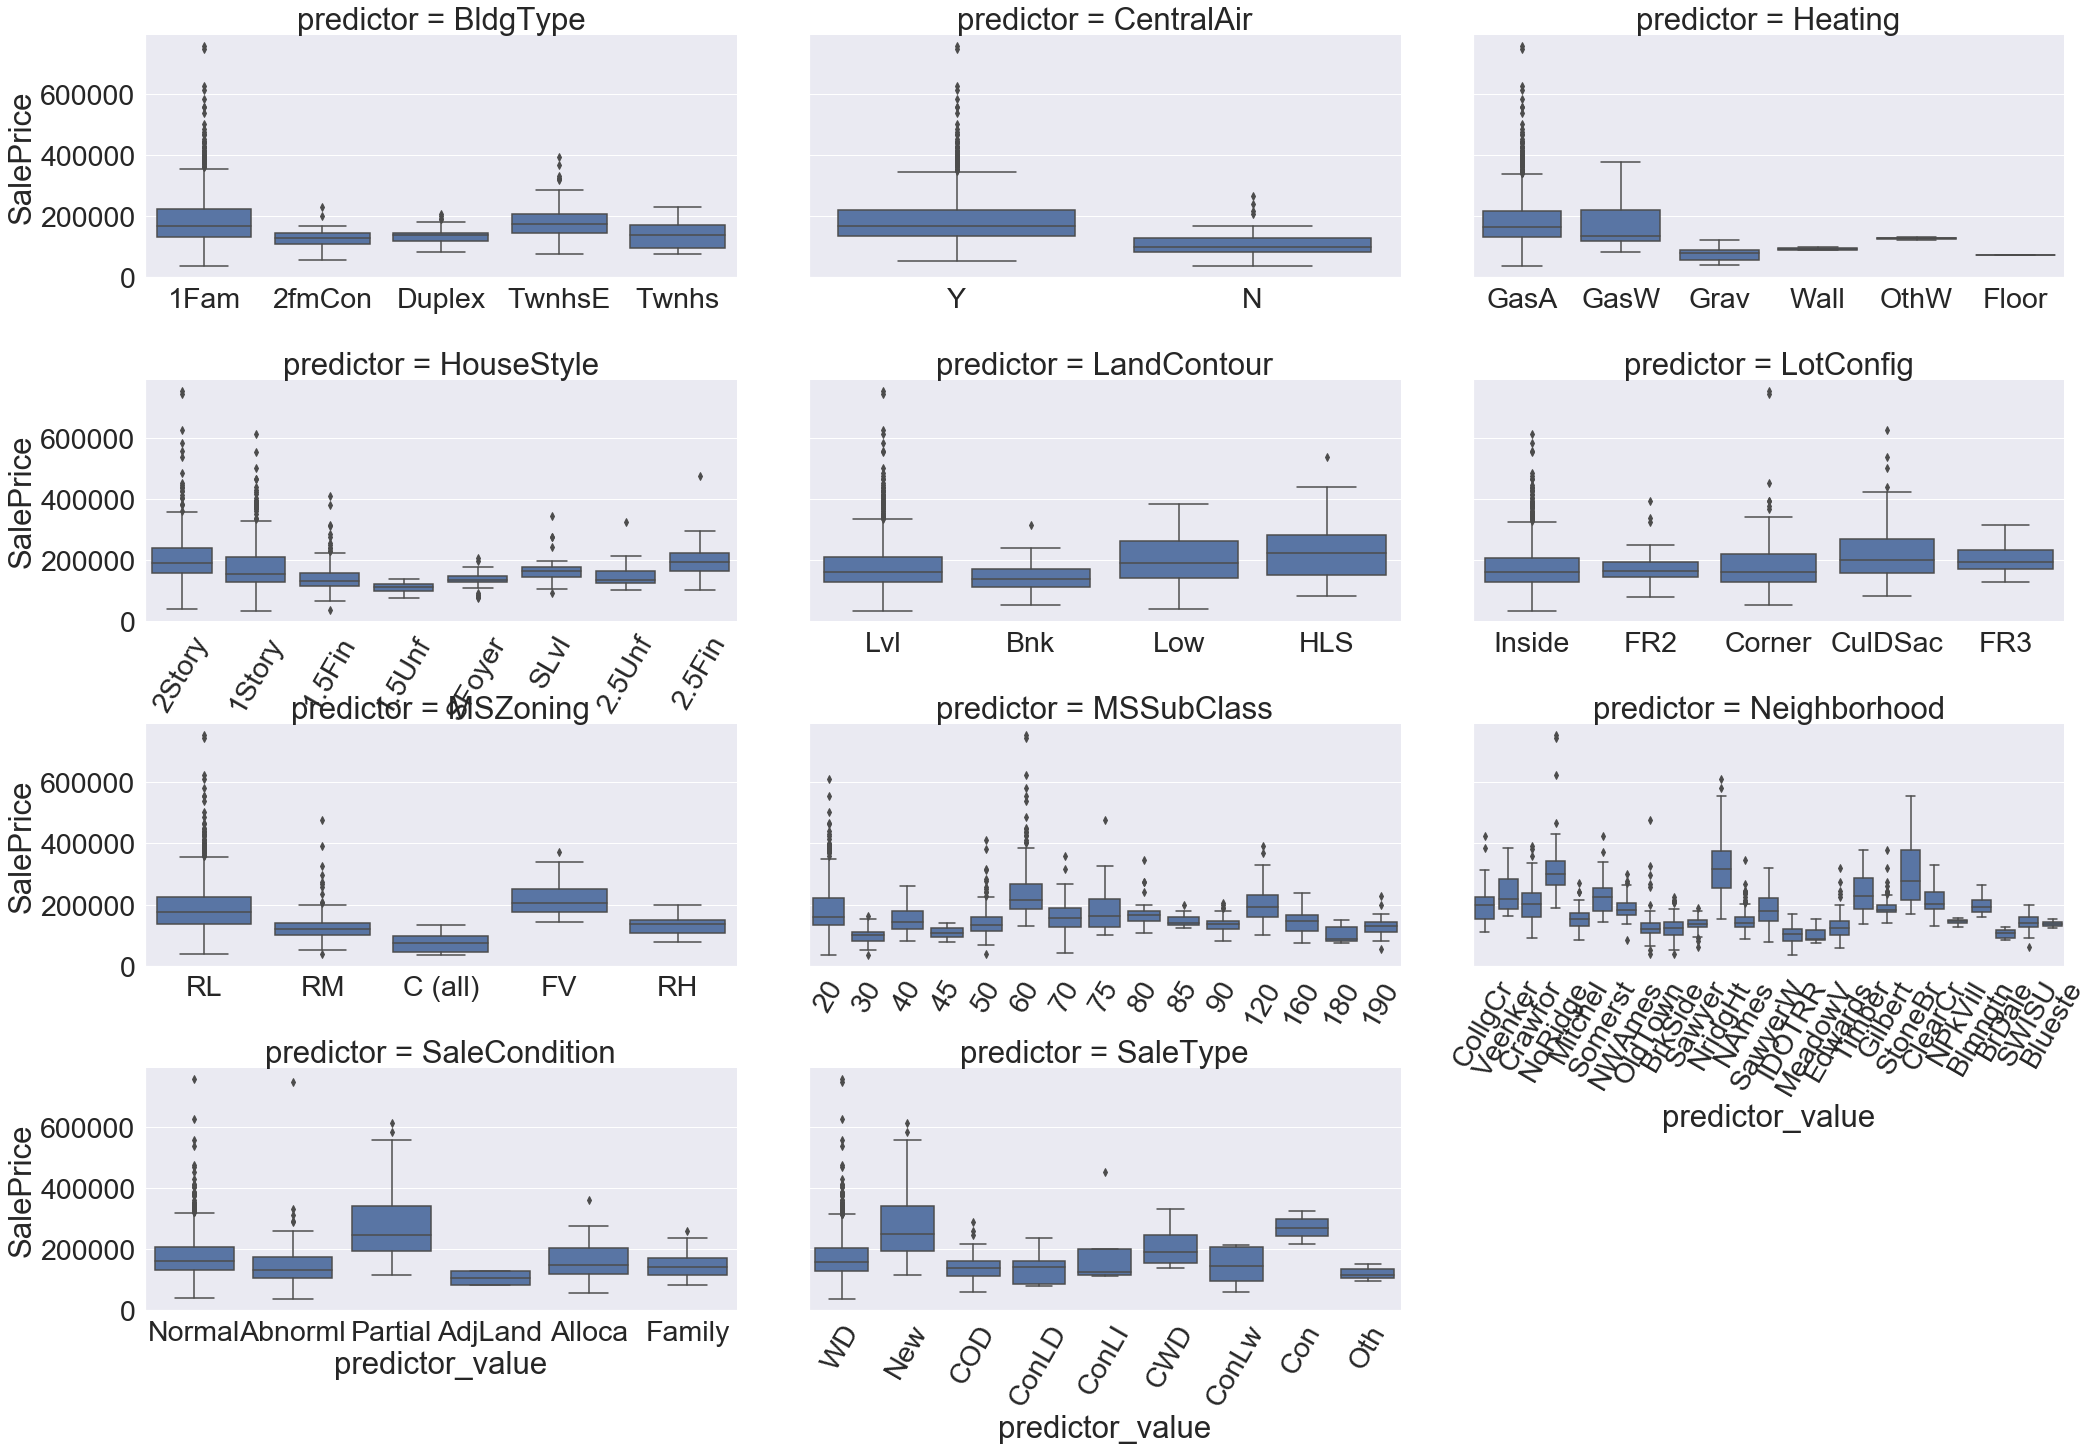

In [25]:
# Nominal predictors and Sale Price
plot_bivariate(X_train, 'SalePrice', nominal_vars, 2.6, 3, 5, 2, sns.boxplot, 
               labels_thresh=7, rotation=60)#rotation=70)

We can see on the following table the prices per square feet on average in the most expensive and cheapest neighborhoods (considering only the price per square feet of the living area):

In [26]:
X_train['Living_Area_'] = X_train['GrLivArea'] + X_train['TotalBsmtSF']
dollar_sf = X_train.groupby(['Neighborhood'])['Living_Area_', 
                                              'SalePrice'].apply(lambda x: np.round(x.mean(), 2))
dollar_sf['$/SF'] = np.round(dollar_sf['SalePrice'] / dollar_sf['Living_Area_'], 2)
display(dollar_sf.sort_values('$/SF', ascending=False).head(2))
display(dollar_sf.sort_values('$/SF', ascending=False).tail(2))

,Living_Area_,SalePrice,$/SF
Neighborhood,,,
StoneBr,3402.08,310499.00,91.27
NridgHt,3518.78,316270.62,89.88


,Living_Area_,SalePrice,$/SF
Neighborhood,,,
SWISU,2648.32,142591.36,53.84
IDOTRR,1889.14,100123.78,53.00


If we group by type of dwelling as well as neighborhood we can even see a bigger difference:

In [27]:
dollar_sf = X_train.groupby(['Neighborhood', 
                             'MSSubClass'])['Living_Area_', 
                                            'SalePrice'].apply(lambda x: np.round(x.mean(), 2))
dollar_sf['$/SF'] = np.round(dollar_sf['SalePrice'] / dollar_sf['Living_Area_'], 2)
display(dollar_sf.sort_values('$/SF', ascending=False).head(2))
display(dollar_sf.sort_values('$/SF', ascending=False).tail(2))

Living_Area_  SalePrice    $/SF
Neighborhood MSSubClass                                 
StoneBr      60               4316.00   444056.0  102.89
             20               3662.29   373885.0  102.09

,,Living_Area_,SalePrice,$/SF
Neighborhood,MSSubClass,,,
IDOTRR,20,1272.0,45652.0,35.89
Edwards,60,6021.0,167412.5,27.80


On average, the price of a square feet of a 2-story dwelling in _Edwards_ is 5 times cheaper than it is in _StoneBr_. This is only an approximation for the sake of illustration since many other features in the set have an influence -to some extent- on the price of the square feet.

This is further explored in this [supervised analysis](ames_housing_prices_models.ipynb 'Predicting Ames Housing Prices: Pipeline Workflow').